# Topology optimization tutorial: Raman molecule

In [2]:
import matplotlib.pyplot as plt
import jax 
import jax.numpy as jnp
from jax import jit
import numpy as np
import os
import design_tools as dt
import maxwell_operator as operator
import jax.experimental.sparse as jsp
import TM_FDFD_jax as TM

jax.config.update('jax_platform_name', 'cpu')
os.environ['JAX_PLATFORMS'] = 'cpu' # This code is a bit faster on GPU for sufficiently large systems, but this is not extensively tested for now. The designs presented in this paper were calculated on CPU.
print(jax.devices()) # This should print a list of CPU or GPU devices. If this errors because you have a JAX GPU build witout a GPU, just run this again. 

[CpuDevice(id=0)]


In [3]:
# Define relevant parameters for the optimization
gpr = 80 # gridpoints per length unit 
wv1 = 1.0 # Wavelength of the pump source
wv2 = 1.0 # Wavelength of the Raman source
alpha = 1.0 # Raman polarizability 
r = 0.3 # Outer radius (corresponds to L = 0.6 in paper)
ri = 0.1 # Inner radius
circle = True 
chi = 10+0.1j # Linear susceptibility
chibkg = 0 # Background susceptibility = vacuum
pml_thick = 0.3 # Thickness of the PML
pml_sep = 0.3 # Separation between the PML and the design region

dl = 1/gpr 
Mx = int(np.round(2*r/dl))+1 # Total number of pixels in design region in x direction, +1 to center the dipole 
My = int(np.round(2*r/dl))+1 # Total number of pixels in design region in y direction
Mi = int(np.round(ri/dl)) # Inner radius of design region
Npml = int(np.round(pml_thick/dl)) 
Npmlsep = int(np.round(pml_sep/dl))
nonpmlNx = Mx + 2*Npmlsep 
nonpmlNy = My + 2*Npmlsep 
Nx = nonpmlNx + 2*Npml
Ny = nonpmlNy + 2*Npml

e0, Z, C = 1, 1, 1
k1, k2 = 2*np.pi/wv1, 2*np.pi/wv2
omega1, omega2 = 2*np.pi*C/wv1, 2*np.pi*C/wv2

Number of pixels in design region: 1596
Design mask shape: (145, 145)


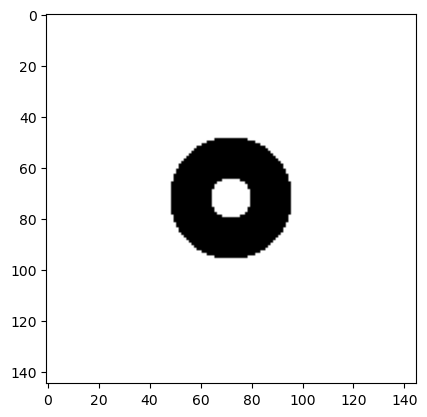

In [4]:
# Initialize a structure and visualize it 
design_mask, ndof = dt.init_domain(Nx, Ny, Mx, My, Mi, Npml, Npmlsep, nonpmlNx, nonpmlNy, circle)
plt.imshow(design_mask, cmap='binary')
print('Number of pixels in design region:', ndof)
print('Design mask shape:', design_mask.shape)

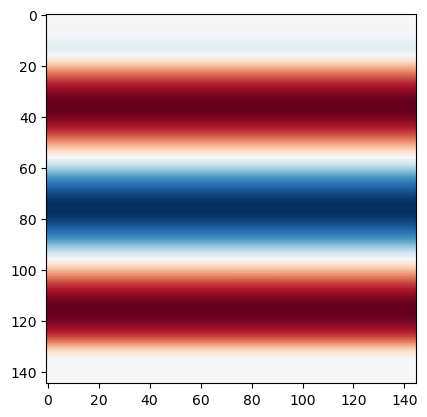

In [5]:
# Initialize the Maxwell operators and calculate the incident field 
M1_np = operator.get_TM_MaxwellOp(wv1, 1/gpr, Nx, Ny, (Npml, Npml), bloch_x=0.0, bloch_y=0.0, Qabs=np.inf)
M2_np = operator.get_TM_MaxwellOp(wv2, 1/gpr, Nx, Ny, (Npml, Npml), bloch_x=0.0, bloch_y=0.0, Qabs=np.inf)
M1 = jsp.BCOO.from_scipy_sparse(M1_np)
M2 = jsp.BCOO.from_scipy_sparse(M2_np)

Ez_line = TM.get_TM_linesource_field(M1, wv1, dl, Nx, Ny, Npml+Npmlsep//2, amp=1, chigrid=None)
plt.imshow(np.real(Ez_line), cmap='RdBu') # Plot incident field

In [7]:
# Define the objective function
def raman_scattered(rho, linex, vacprad):
    chigrid = dt.getchi(rho, chi, chibkg, Nx, Ny, design_mask) # get the distribution of chi

    Ez_line = TM.get_TM_linesource_field(M1, wv1, dl, Nx, Ny, linex, amp=1, chigrid=chigrid) # simulate the incident field
    amp = -1j*omega2*alpha*Ez_line[Npml:-Npml, Npml:-Npml][nonpmlNx//2, nonpmlNy//2] # calculate the resulting amplitude of dipole
    Ez = TM.get_TM_dipole_field(M2, wv2, dl, Nx, Ny, Nx//2, Ny//2, amp=amp, chigrid=chigrid) # simulate the Raman field

    ldos = -0.5 * jnp.real((amp.conjugate() * Ez[Npml:-Npml, Npml:-Npml][nonpmlNx//2, nonpmlNy//2]))/vacprad # calculate the LDOS
    absorbed = jnp.real((omega2/2)*jnp.real(jnp.sum(jnp.conjugate(Ez[design_mask])*Ez[design_mask] * jnp.imag(chigrid[design_mask]))*dl*dl)) / vacprad # calculate the absorbed power 
    
    # jax.debug.print("ldos = {x}, abs = {y}, scat = {z}", x = ldos, y=absorbed, z=ldos-absorbed)

    scattered_power = ldos - absorbed
    return -scattered_power # - sign because we want to maximize the scattered power

# Calculate the vaccuum power radiated by the dipole (normalization factor)
vacprad = -raman_scattered(jnp.zeros(ndof), Npml+Npmlsep//2, 1)

# Define the problem-specific objective function 
loss = jit(lambda rho: raman_scattered(rho, Npml+Npmlsep//2, vacprad))


-1.0474739


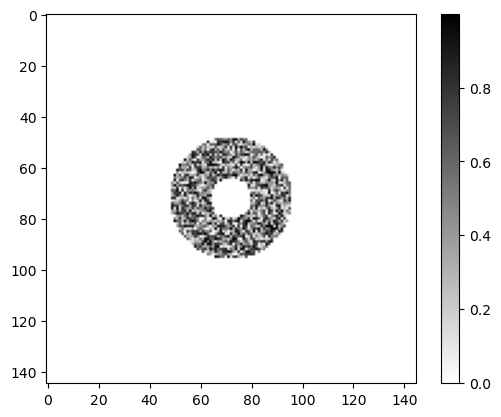

In [8]:
# Function to embed the design into a larger grid for plotting 
def embed_rho(rho):
    big_rho = np.zeros((Nx, Ny))
    big_rho[design_mask] = rho
    return big_rho 

# init_rho = jnp.ones(ndof)/2 # Initialize the design to be a uniform distribution of material
np.random.seed(0) # Use this seed to get the same result every time.
init_rho = jnp.array(np.random.random(ndof))
plt.imshow(embed_rho(init_rho), cmap='binary')
plt.colorbar()

print(loss(init_rho)) # Check that the loss function is working

In [11]:
# Newer iterations of this code use optax (which is meant to replace jaxopt), but this paper utilizes jaxopt. 

# Older jaxopt method (still works, replicate paper)
# import jaxopt 
# maxiter = 100
# lb = jnp.zeros_like(init_rho) # lower and upper bounds on rho for projected gradient descent 
# up = jnp.ones_like(init_rho)
# pg = jaxopt.ProjectedGradient(fun=loss, projection=jaxopt.projection.projection_box, maxiter=maxiter, jit=True)
# # Run the optimization
# pg_sol = pg.run(init_rho, hyperparams_proj=(lb, up))
# rho_opt = pg_sol.params

# Newer optax method 
gloss = jax.grad(loss)
import optax
step = 0
eps_conv = 1e-5
miniter = 20
maxiter = 100
lr = 0.01 # learning rate 
rho_opt = init_rho

current_loss = loss(rho_opt)
old_loss = np.inf
print(f'initial loss: {current_loss}') # ( will print negative, we are minimizing -objective)
print(f'number of optimization parameters: {len(rho_opt)}')

solver = optax.adam(learning_rate = lr)
opt_state = solver.init((rho_opt))

while ((np.abs((old_loss - current_loss)/current_loss) > eps_conv) or (step < miniter)) and (step < maxiter):
    old_loss = current_loss
    gradient = gloss(rho_opt)
    updates, opt_state = solver.update(gradient, opt_state, (rho_opt))
    rho_opt = optax.apply_updates((rho_opt), updates)
    
    current_loss = loss(rho_opt)

    if step % 1 == 0:
        print(f'step {step}, loss: {-current_loss}')

    step += 1



initial loss: -1.0474739074707031
number of optimization parameters: 1596
step 0, loss: 1.1794824600219727
step 1, loss: 1.3246597051620483
step 2, loss: 1.4838345050811768
step 3, loss: 1.6594611406326294
step 4, loss: 1.8522292375564575
step 5, loss: 2.0636343955993652
step 6, loss: 2.294459581375122
step 7, loss: 2.5438694953918457
step 8, loss: 2.8082361221313477
step 9, loss: 3.0785741806030273
step 10, loss: 3.341015100479126
step 11, loss: 3.584763288497925
step 12, loss: 3.8110103607177734
step 13, loss: 4.031520366668701
step 14, loss: 4.258117198944092
step 15, loss: 4.49700403213501
step 16, loss: 4.7449870109558105
step 17, loss: 4.997613430023193
step 18, loss: 5.251370906829834
step 19, loss: 5.50606107711792
step 20, loss: 5.767202854156494
step 21, loss: 6.044768333435059
step 22, loss: 6.347787380218506
step 23, loss: 6.678610801696777
step 24, loss: 7.037794589996338
step 25, loss: 7.423501491546631
step 26, loss: 7.8355021476745605
step 27, loss: 8.277497291564941
st

89.622154


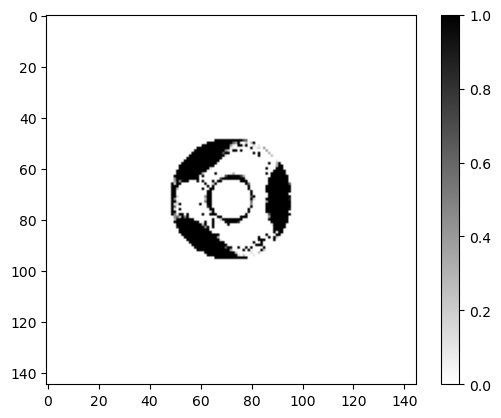

In [ ]:
# Visualize final structure and compute its performance.
rho_clip = jnp.clip(rho_opt, 0, 1) # Gradient to increase rho beyond 1 should be zero, but it may still happen due to overstepping a gradient step (the objective clips it, so it doesn't improve the objective to take rho > 1 or rho rho < 0). We clip it at the end for plotting purposes. 
plt.imshow(embed_rho(rho_clip).T, cmap='binary') # Transpose to fit convention in paper (source from left not top)
plt.colorbar()

# Calculate the performance of the design
print(-loss(rho_clip))

# Performance of L = 0.6, dielectric should be slightly over 100 (see Fig 3). Here we get a performance of ~90 without too much effort, and a design that looks very similar to the presented one in Fig 3, top left. 
# One technique to fine-tune designs used in the paper is to run lower resolution designs (as done here) then iteratively feeding lower resolution designs into higher-resolution runs to refine the design. Thsi can eek out more performance in these inverse designs. 